In [1]:
import os
import matplotlib
matplotlib.use("Agg")
import numpy as np
from numpy import pi
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import logging,argparse
from data_loader import Data_loader
import model 
from hyperparams import Hyperparameters
import utils
from commons import tf_transform
import graph
from termcolor import colored 
import model_componets as comps
from commons import transform_util




print colored("code started","red")

H = Hyperparameters ()

D = Data_loader(H.data_path,H.seq_length,H.batch_size)


os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)


input_ph = tf.placeholder(tf.float32, shape= [None , H.num_joints ,3],name = 'skeleton_input')

global_step = tf.train.get_or_create_global_step()

x_input = input_ph

x_input_view_norm,x_input_local,tr_mats = comps.root_relative_to_local(x_input)

encoder_out = graph.apply_pose_encoder(input_ph)

pose_encoder_params = graph.get_network_params("Encoder_net")

encoder_input = tf.reshape(encoder_out,(-1,H.seq_length,32))

encoder_lstm_out = model.apply_encoder(encoder_input,name ='motion_encoder')

z_state = encoder_lstm_out['z_state']

z_outputs = encoder_lstm_out['z_outputs']

decoder_lstm_out = model.apply_decoder(z_state,z_outputs,name = 'motion_decoder')

motion_recon = decoder_lstm_out['x_recon']

motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

pose_recon = graph.apply_pose_decoder(motion_recon_reshaped)#view norm

pose_decoder_params = graph.get_network_params("Decoder_net")

param_lstm_encoder = model.get_network_params('motion_encoder')

param_lstm_decoder = model.get_network_params('motion_decoder')

sess.run(tf.global_variables_initializer())

print colored("loading weights","blue")

tf.train.Saver(pose_encoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001') 
print colored("loaded pose_encoder weights","yellow")

tf.train.Saver(pose_decoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001')
print colored("loaded pose_decoder weights","blue")

tf.train.Saver(param_lstm_encoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/backup/weights/lstm_encoder/'))
print colored("loaded pose lstm_encoder weights","green")

tf.train.Saver(param_lstm_decoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/backup/weights/lstm_decoder/'))
print colored("laoded pose lstm_decoder weights","red")


code started
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
loading weights
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001
loaded pose_encoder weights
INFO:tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from other_utils import np_utils, sk_utils
import imageio


In [3]:
train_batch = np.asarray(D.get_sequence_batch_train())

train_batch = train_batch[:,0:30]

train_batch = np.reshape(utils.augment_pose_seq(train_batch),(-1,H.num_joints * 3))

train_batch = train_batch.reshape((-1,H.num_joints , 3))

angles,train_batch_view_norm,train_batch_local = transform_util.root_relative_to_local_skeleton_batch(train_batch)

feed_dict = {x_input : train_batch}

op_train_dict = sess.run({'embedding':z_state, 'final_pose': pose_recon}, feed_dict=feed_dict)

predictions = op_train_dict['embedding']

print train_batch

[[[ 0.          0.          0.        ]
  [ 1.17997957  0.2101639   4.59630062]
  [-0.14004838 -0.14614896  4.68271456]
  ...
  [ 0.96517943  0.15212155 -0.38443167]
  [ 1.95527678 -3.85126906 -1.1797749 ]
  [ 1.04371263 -1.16382    -3.39487497]]

 [[ 0.          0.          0.        ]
  [ 1.18744638  0.19363765  4.59510343]
  [-0.12750077 -0.18070874  4.68273191]
  ...
  [ 0.96441464  0.16569067 -0.38072433]
  [ 2.0212105  -3.81136693 -1.22107866]
  [ 1.05656135 -1.12566991 -3.4157275 ]]

 [[ 0.          0.          0.        ]
  [ 1.19986195  0.16760962  4.59290086]
  [-0.10379145 -0.24330588  4.68529282]
  ...
  [ 0.96188046  0.19353334 -0.37393961]
  [ 2.13557434 -3.72374369 -1.33174091]
  [ 1.04831534 -1.04165    -3.47282505]]

 ...

 [[ 0.          0.          0.        ]
  [-0.31399475 -0.27106109  4.73185304]
  [-1.16068201  0.79498295  4.88538093]
  ...
  [ 0.55946898 -0.88323582 -0.09689659]
  [-2.26666079 -3.1372223  -2.23524536]
  [-2.36196211 -2.65356144 -5.80133423]]

 [

In [4]:
mean = np.mean(predictions, axis=0)
std = np.std(predictions,axis=0)

print mean.shape
print std.shape

# x_pred = dms.decode(predictions)
# x_pred.shape

# imgs = sk_utils.get_skeleton_images(x_pred[0], title_prefix='p')
# len(imgs)
print('minimum vaue of mean ', min(mean))
print('minimum value of std ', min(std))
print('maximum value of mean', max(mean))
print('maximum value of std', max(std))

(128,)
(128,)
('minimum vaue of mean ', -4.462292)
('minimum value of std ', 0.3697875)
('maximum value of mean', 3.4766681)
('maximum value of std', 2.1667154)


In [5]:
sample_1 = mean+(4*std)
sample_2 = mean-(4*std)
sample_1 = np.reshape(sample_1 , (1,128))
sample_2 = np.reshape(sample_2 , (1,128))
map_d = 120


In [6]:
a = np.linspace(0,1, map_d)
a = np.reshape(a, (map_d,1))


vertical = a*sample_1[:,:64] + (1-a)*sample_2[:,:64]

assert (vertical[0] == sample_2[0,:64]).all()


horizontal = a*sample_1[:,64:] + (1-a)*sample_2[:,64:]

assert (horizontal[0] == sample_2[0,64:]).all()

In [7]:
grid = np.empty((map_d,map_d,128))

for i in range(map_d):
    for j in range(map_d):
        grid[i,j] = np.concatenate((vertical[i], horizontal[j]))
        
grid_flat = np.reshape(grid, (-1,128))
print grid.shape
print grid_flat.shape

(120, 120, 128)
(14400, 128)


In [8]:
sess1 = tf.InteractiveSession(config=config)

embed_ph = tf.placeholder(tf.float32 , shape = [None ,128],name = "embed")

final_state_fced_stacked = tf.stack([embed_ph]*30, 1)

decoder_lstm_out = model.apply_decoder(embed_ph,final_state_fced_stacked,name = 'motion_decoder')

motion_recon = decoder_lstm_out['x_recon']

motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

pose_recon1 = graph.apply_pose_decoder(motion_recon_reshaped)#view norm

param_lstm_decoder1 = model.get_network_params('motion_decoder')

pose_decoder_params1 = graph.get_network_params("Decoder_net")

# sess1.run(tf.global_variables_initializer())

print colored("loading weights","blue")

tf.train.Saver(pose_decoder_params).restore(sess1,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001')
print colored("loaded pose_decoder weights","blue")

tf.train.Saver(param_lstm_decoder1).restore(sess1,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/backup/weights/lstm_decoder/'))
print colored("loaded pose lstm_decoder weights","red")

poses_for_grid = sess1.run(pose_recon1,feed_dict = {embed_ph : grid_flat})

print poses_for_grid

/virtual_envs/ani_python2.7/local/lib/python2.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


loading weights
INFO:tensorflow:Restoring parameters from ../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001
loaded pose_decoder weights
INFO:tensorflow:Restoring parameters from ../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/backup/weights/lstm_decoder/rule_based_motion_net_expt_seq309100
loaded pose lstm_decoder weights
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 1.34275496e-01  3.27368500e-04  4.74810171e+00]
  [ 1.49630356e+00  6.92086876e-04  4.60052538e+00]
  ...
  [-1.04841495e+00  4.36165817e-02 -3.77273634e-02]
  [-1.12611449e+00  3.85129404e+00 -1.80847406e+00]
  [-2.09310126e+00  1.20040703e+00 -4.04403257e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 9.76454318e-02  1.53386302e-03  4.74899626e+00]
  [ 1.43384576e+00 -1.07818656e-01  4.46702099e+00]
  ...
  [-1.04783034e+00  3.47047523e-02 -5.78509346e-02]
  [-1.06060195e+00  3.03962255e+00 -2.99218130e+00]
  [-1.87480903e+00 -3.36869717e-0

In [9]:
predictions =  poses_for_grid.reshape(-1,30,15,3)

In [10]:
predictions = np.mean(predictions, axis=-1)
predictions = np.mean(predictions, axis=-1)

print predictions.shape

velocity = predictions[:,1:] - predictions[:,:-1]
speed = np.absolute(velocity)

print(speed.shape)

speed  = np.mean(speed, axis=-1)

speed = np.reshape(speed, (map_d,map_d))

print(speed.shape)


(14400, 30)
(14400, 29)
(120, 120)


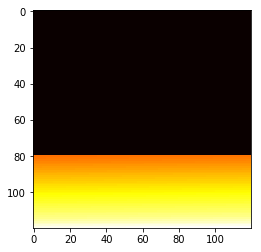

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.imshow(speed, cmap='hot', interpolation='nearest')
# plt.savefig("test.svg", format="svg")
plt.show()

In [12]:
print speed


[[4.2364359e-02 4.1893311e-02 4.1353576e-02 ... 4.9853686e-02
  4.9637560e-02 4.9273971e-02]
 [4.2474668e-02 4.2051028e-02 4.1575916e-02 ... 5.0474375e-02
  5.0217524e-02 4.9823560e-02]
 [4.2586271e-02 4.2224843e-02 4.1786529e-02 ... 5.0979842e-02
  5.0845452e-02 5.0569855e-02]
 ...
 [2.8863802e+30 2.8869025e+30 2.8874247e+30 ... 2.9474842e+30
  2.9480064e+30 2.9485287e+30]
 [2.9490509e+30 2.9495732e+30 2.9500954e+30 ... 3.0101549e+30
  3.0106771e+30 3.0111994e+30]
 [3.0117216e+30 3.0122439e+30 3.0127662e+30 ... 3.0728256e+30
  3.0733478e+30 3.0738701e+30]]
